<a href="https://colab.research.google.com/github/goya5858/OSERO/blob/main/DQN_OTHELLO_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import torch.multiprocessing as mp
import time

import copy

import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gym
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F

from tqdm.notebook import tqdm

import matplotlib.patches as pat
import seaborn as sns

# Agent

In [21]:
class CNN_Brain(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(64*8*8, 64)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.flatten(x)
        x = self.fc1(x)
        return x

# Actor-Critic系への転用も見据えてpi, Vのダブルヘッド

class CNN_Brain(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)

        self.drop1 = nn.Dropout(p=0.3)
        self.drop2 = nn.Dropout(p=0.3)
        self.drop3 = nn.Dropout(p=0.3)
        self.drop4 = nn.Dropout(p=0.3)

        self.flatten = nn.Flatten()

        self.pi_net = nn.Linear(64*8*8, 64)
        self.pi_act = nn.Softmax()

        self.V_net = nn.Linear(64*8*8, 1)

    def forward(self, x):
        x  = self.relu(self.bn1(self.conv1(x)))
        x  = self.drop1(x)

        x  = self.relu(self.bn2(self.conv2(x)))
        x  = self.drop2(x)

        x  = self.relu(self.bn3(self.conv3(x)))
        x  = self.drop3(x)

        x  = self.relu(self.bn4(self.conv4(x)))
        x  = self.flatten(x)
        x  = self.drop4(x)

        pi = self.pi_act( self.pi_net(x) )
        V  = self.V_net(x)
        return pi, V

In [4]:
from collections import namedtuple
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'state_next'))

class Agent_Memory():
    def __init__(self):
        self.capacity = CAPACITY #メモリの大きさ
        self.memory = []
        self.index = 0

    def sample(self, BATCH_SIZE):
        '''batch_size分だけ、ランダムに保存内容を取り出す'''
        if len(self.memory) < BATCH_SIZE:
            BATCH_SIZE = len(self.memory)

        transitions = random.sample(self.memory, BATCH_SIZE) #BATCH_SIZEの分だけランダムにデータを取り出す
        BATCH = Transition(*zip(*transitions)) #State, Action, Reward, State_Nextの各要素ごとにまとめ直す

        State_BATCH      = torch.tensor( np.concatenate( BATCH.state, axis=0 ) ,dtype=torch.float)
        Action_BATCH     = torch.tensor( np.stack( BATCH.action ) ,dtype=torch.int64)
        Reward_BATCH     = torch.tensor( np.stack( BATCH.reward ) ,dtype=torch.float)
        State_Next_BATCH = np.array( BATCH.state_next ) 
        non_final_mask   = [s is not None for s in State_Next_BATCH]
        State_Next_BATCH = torch.tensor( np.concatenate(State_Next_BATCH[non_final_mask], axis=0 ) ,dtype=torch.float)
        return State_BATCH, Action_BATCH, Reward_BATCH, State_Next_BATCH, non_final_mask

    def put_memory(self, state, action, reward, state_next):
        '''transition = (state, action, reward, state_next)をメモリに保存する'''
        if len(self.memory) < self.capacity:
            self.memory.append(None)  # メモリが満タンでないときは足す
        self.memory[self.index] = Transition(state, action, reward, state_next)
        self.index = (self.index + 1) % self.capacity  # 保存するindexを1つずらす

In [24]:
class Agent():
    def __init__(self):
        self.Network = CNN_Brain()
        self.Network.load_state_dict( torch.load(MODEL_PATH, map_location=torch.device(DEVICE)) )
        self.Memory  = Agent_Memory()
        self.optim   = optim.Adam(self.Network.parameters(), lr=RL)
        self.lr_scheduler = optim.lr_scheduler.StepLR(optimizer=self.optim, step_size=SCH_STEP_SIZE, gamma=SCH_GAMMA)

    def get_action(self, state, episode=500): 
        # ε-greedy法で徐々に最適行動のみを採用する
        #epsilon = 0.5 * (1 / (episode + 1))
        epsilon = 0
        if epsilon <= np.random.uniform(0, 1):
            self.Network.eval()  # ネットワークを推論モードに切り替える
            with torch.no_grad():
                #Q_values, _ = self.Network( torch.tensor( state, dtype=torch.float ) )
                Q_values = self.Network( torch.tensor( state, dtype=torch.float ) )
                action = Q_values.argmax().detach().numpy()
                #m = Categorical( F.softmax(Q_values) )
                #action = m.sample().detach().numpy()[0]
        #else:
        #    action = np.random.choice( 64 )   # 0-63 の行動をランダムに返す
        #    action = np.array(action)
        return action

    def update_Network(self, BATCH_SIZE):
        if len(self.Memory.memory) < BATCH_SIZE:
            BATCH_SIZE = len(self.Memory.memory)
        
        if len(self.Memory.memory) < 2:
            # memoryの長さが2未満の場合、State_NextのBATCHがNoneのみのため何もしない
            return 
        self.Network.train().to(DEVICE)
        # Memoryから学習用のデータをランダムに取り出す
        State_BATCH, Action_BATCH, Reward_BATCH, State_Next_BATCH, non_final_mask = self.Memory.sample(BATCH_SIZE)
        #Q_values = self.Network(State_BATCH.to(DEVICE))[0].gather(1, Action_BATCH.reshape(-1,1).to(DEVICE)) # Action_BATCHのshapeは(-1)ではなく、(-1,1)の二次元である必要がある
        Q_values = self.Network(State_BATCH.to(DEVICE)).gather(1, Action_BATCH.reshape(-1,1).to(DEVICE)) # Action_BATCHのshapeは(-1)ではなく、(-1,1)の二次元である必要がある
        
        next_Q_values = torch.zeros(BATCH_SIZE).to(DEVICE) #全部0で初期化しておいて、non_finalの場所だけ計算する
        #next_Q_values[non_final_mask] = self.Network(State_Next_BATCH.to(DEVICE))[0].max(1)[0].detach()
        next_Q_values[non_final_mask] = self.Network(State_Next_BATCH.to(DEVICE)).max(1)[0].detach()
        # max()メソッドで最大値を計算した後、[0]で数値を取り出す必要がある, detach()で勾配を消しておく    

        true_Q_values =  (Reward_BATCH.to(DEVICE)+ GAMMA * next_Q_values).unsqueeze(1)  #2次元配列に変換
        loss = F.smooth_l1_loss(Q_values, true_Q_values)

        self.optim.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.Network.parameters(), GClip)
        self.optim.step() 
        self.lr_scheduler.step()
        self.Network.to('cpu')
    
    def memorize(self, state, action, reward, state_next):
        self.Memory.put_memory(state, action, reward, state_next)

# Task

In [19]:
class CPU_Agent():
    def __init__(self):
        self.Network = CNN_Brain()
        self.Network.load_state_dict( torch.load(CPU_MODEL_PATH, map_location=torch.device(DEVICE))) 
        self.Network = self.Network.to(DEVICE)

    def get_action(self, state, episode=500): 
        # ε-greedy法で徐々に最適行動のみを採用する
        epsilon = 0.5 * (1 / (episode + 1))
        state = make_3d(state)
        if epsilon <= np.random.uniform(0, 1):
            self.Network.eval()  # ネットワークを推論モードに切り替える
            with torch.no_grad():
                Q_values = self.Network( torch.tensor( state, dtype=torch.float ).to(DEVICE) )
                action = Q_values.argmax().cpu().detach().numpy()
                #m = Categorical( F.softmax(Q_values) )
                #action = m.sample().detach().numpy()[0]
        else:
            action = np.random.choice( 64 )   # 0-63 の行動をランダムに返す
            action = np.array(action)
        return action

In [7]:
# 対戦相手
# 置ける場所にランダムに置いていく

class Random_Player:
    def __init__(self):
        pass
    
    def get_action(self, board):
        puttables = self.check(board)    #print("CPU puttables", puttables)
        basho = random.choice(puttables) #print("CPUs action", action)
        action = 8 * basho[1] + basho[0] #basho=(x, y)の時、action=8*y+x なので、(x, y)=(action%8, action//8) 
        return action
    
    def check(self, board): #今回の手番の人が打てる場所をリストアップする
        okeru_list = []
        for x in range(8):
            for y in range(8):
                plc = board[y, x]
                if plc == 0: #もし今回のplaceに何も置いていなければ8方向探索する
                    able = self.octpass([x,y], board) #今回の場所に置いたときひっくり返せる場所をリストアップする
                    if len(able) > 0: #もしひっくり返せる場所が0ではないなら置ける場所リストに今回の場所を追加する
                        okeru_list.append([x,y])
        return okeru_list
    
    def octpass(self, basho, board): #今回置きたい場所を渡したら８方向探索するメソッド
        basho_list = set() #今回ひっくり返せる場所のリスト(setクラスを使う→重複なしで扱える)

        if board[basho[1], basho[0]] != 0:
            pass #print('既に石が置かれています')
        else:
            for x in [-1,0,1]:
                for y in [-1,0,1]: #8方向を順に見ていく
                    tmp = [] #今回の確認する方向でひっくり返そうな場所を一時的に記憶しておくリスト

                    if x == 0 and y == 0:
                        pass #方向がないときはパスする

                    for length in range(1,9): #今回確認する方向にだんだん腕を伸ばしていく
                        if 0<=basho[1]+y*length<=7 and 0<=basho[0]+x*length<=7: #腕が盤面に収まるのなら
                            check_plc = board[basho[1]+y*length, basho[0]+x*length]
                            if check_plc == 0: #もし確認した場所に何も置いていなければ、飛び石になっちゃうので手を伸ばすのを終了
                                break
                            elif check_plc == -1: #もし確認した場所が相手プレイヤーの石だった場合その場所を一時記憶しておく
                                tmp.append( (basho[0]+x*length, basho[1]+y*length) )
                            elif check_plc == 1: #もし確認した場所が自分の石だった場合、ひっくり返せるリストに現在ひっくり返せそうな場所を追加して腕を伸ばすのをやめる
                                if len(tmp) > 0: #中身がからでない場合のみ
                                    basho_list |= set(tmp)
                                break #手を伸ばすのを終了

                        else: #もし盤面を飛び出してしまうならpassする
                            pass
        return list(basho_list)

In [8]:
# オセロ自体のクラス
# 盤面を持っており、石をおくとひっくり返す
# もしすでに置いてある場所や不適切な場所に置いた場合、空のリストを返す

class OTHELLO:
    def __init__(self, player_color='B'):
        self.player = player_color

        # 差し手の色が1, 相手(CPU)の色が-1
        self.board = np.zeros((8,8)).astype(np.int8)
        self.board[3,4] = self.board[4,3] = -1
        self.board[3,3] = self.board[4,4] = 1
        if self.player == 'W': #もし差し手が白なら1, -1を反転する
            self.board *= -1
    
    def put(self, basho, player='human'):
        # basho = (x, y) の形式
        # 盤面の"basho"の位置を確認して、正しい手であったなら石を置いてひっくり返し、新たな盤面を返す
        # 不適切な手であった場合、空のリストを返す

        if self.board[ basho[1], basho[0] ] != 0: #既に石が置いてある場合、空のリストを返す
            return [] #print('すでにおいてあります')
 
        if player != 'human':
            self.board*=-1 # もし差し手がCPUの場合、敵味方のラベルを入れ替える

        reversibles = self.octpass(basho)
        if reversibles: #ひっくり返せる場所があるなら、その場所に石を置いてひっくり返していく
            self.board[basho[1], basho[0]] = 1
            for reversible_basho in reversibles:
                self.board[reversible_basho[1], reversible_basho[0]] = 1
            if player != 'human':
                self.board*=-1 # もし差し手がCPUの場合、敵味方のラベルを入れ替え直す
            return self.board

        else: # もしひっくり返せる場所においてなかった場合、石をおかないで空のリストを返す
            if player != 'human':
                self.board*=-1 # もし差し手がCPUの場合、敵味方のラベルを入れ替え直す
            return []
        
          
    def check(self, player='human'):
        # 盤面を渡すと、今回置ける場所を返してくれる
        # 0が置いてない場所、1が自分の意思がある場所、-1が相手の石が置いてある場所
        okeru_list = []
        if player != 'human':
            self.board*=-1
        for x in range(8):
            for y in range(8):
                plc = self.board[y, x]
                if plc == 0: #もし今回のplaceに何も置いていなければ8方向探索する
                    able = self.octpass([x,y]) #今回の場所に置いたときひっくり返せる場所をリストアップする
                    if len(able) > 0: #もしひっくり返せる場所が0ではないなら置ける場所リストに今回の場所を追加する
                        okeru_list.append([x,y])
        if player != 'human':
            self.board*=-1
        return okeru_list
  
    def octpass(self, basho): 
        # 今回置きたい場所を渡したら８方向探索するメソッド
        # 今回ひっくり返せる場所が帰ってくる
        basho_list = set() #今回ひっくり返せる場所のリスト(setクラスを使う→重複なしで扱える)

        if self.board[basho[1], basho[0]] != 0:
            #print('既に石が置かれています')
            pass
        else:
            for x in [-1,0,1]:
                for y in [-1,0,1]: #8方向を順に見ていく
                    tmp = [] #今回の確認する方向でひっくり返そうな場所を一時的に記憶しておくリスト

                    if x == 0 and y == 0:
                        pass #方向がないときはパスする

                    for length in range(1,9): #今回確認する方向にだんだん腕を伸ばしていく
                        if 0<=basho[1]+y*length<=7 and 0<=basho[0]+x*length<=7: #腕が盤面に収まるのなら
                            check_plc = self.board[ basho[1]+y*length, basho[0]+x*length ]
                            if check_plc == 0: #もし確認した場所に何も置いていなければ、飛び石になっちゃうので手を伸ばすのを終了
                                break
                            elif check_plc == -1: #もし確認した場所が相手プレイヤーの石だった場合その場所を一時記憶しておく
                                tmp.append( (basho[0]+x*length, basho[1]+y*length) )
                            elif check_plc == 1: #もし確認した場所が自分の石だった場合、ひっくり返せるリストに現在ひっくり返せそうな場所を追加して腕を伸ばすのをやめる
                                if len(tmp) > 0: #中身がからでない場合のみ
                                    basho_list |= set(tmp)
                                break #手を伸ばすのを終了

                        else: #もし盤面を飛び出してしまうならpassする
                            pass
        return list(basho_list)

In [57]:
# オセロを実行するタスク本体
# オセロゲーム自体と、対戦相手(CPU)を持つ

# Instance.reset() メソッドで初期化
# state_next, reward, done, info = Instance.step( action )
# 上記のようにcart poleのように使える
# infoは形だけで中身は  "自分に打てる手がある かつ 相手が打てる手がない"　の判断として使ってる 

# Human-Playerが先手の場合、player_color='B'
# Human-Playerが後手の場合、player_color='W'
# で設定する

class OTHELLO_Task:
    def __init__(self, player_color='B', view_board=False):
        self.player_color = player_color
        self.view_board = view_board

        self.GAME = OTHELLO(player_color=self.player_color)

        if CPU_MODEL_PATH=="random":
            self.CPU_Player = Random_Player()
        else:
            self.CPU_Player = CPU_Agent()
        self.Support_CPU_Player = Random_Player() #ルール外の手を打ったときに代わりに正しいところにランダムに打つ
    
    def reset(self):
        self.GAME = OTHELLO(player_color=self.player_color)
        state_next = self.GAME.board
        if self.player_color == 'W':
            # もし人間が後手(白)だった場合、CPUに初めの一手を打たせる
            state_next, reward, done, info = self.step_cpu()
        return state_next

    
    def step(self, action):
        # step_humanとstep_cpuを両方行い、最終的なState_nextを返す
        # done : どちらもおくことができない状態 = ゲーム終了
        # info : 自分は置くことができるが、相手は置くことができない状態 = 連続手番
        state_next, reward, done, info = self.step_human(action)
        if done or info: #　ゲーム終了 or CPUの置く場所がない なら現在のReward, State_nextを返す
            return state_next, reward, done, info
        else: # ゲーム終了でなく、CPUに置ける場所がある場合、CPUが石を置く
            info = True 
            while info: # CPUに置ける場所があって、人間側に置けるところがない場合
                state_next, reward_, done, info = self.step_cpu()
            return state_next, reward+reward_, done, info
            
    
    def step_human(self, action): 
        basho = ( action%8, action//8 ) #actionは0-63なので(8,8)の二次元に変換する

        if self.view_board:
            state = self.GAME.board
            print("\n Humans state Input !!!!!!!!!!!!!!!!!")
            plt_img(state=state)
            print('Humans Action :', basho)

        state_next = self.GAME.put(basho, player='human')
        info = False
        reward = 0

        if len(state_next) ==0: # 自分が間違えた場所に置いた場合  state_next=[]になるのはミスした時だけ
            # Support_CPUがランダムに置ける場所に置いてくれる
            print('you missed')
            MISS_count.append(1)
            state = self.GAME.board 
            action = self.Support_CPU_Player.get_action( state )
            basho = ( action%8, action//8 ) #actionは0-63なので(8,8)の二次元に変換する
            state_next = self.GAME.put(basho, player='human')

            reward = -1*PENALTY
            done = False
            info = False

        if self.GAME.check(player='cpu'): 
            # 人間が打った後の盤面で、CPUに打てる手がある場合
            done = False
        else: #相手(CPU)に置ける場所がなかった場合
            if self.GAME.check(player='human'): 
                # 自分に置ける場所があるなら
                info = True #相手番はpass
                done = False
            else:
                #自分にも置ける場所がないなら
                done = True
                if sum(sum(self.GAME.board)) > 0: #自分の石の方が多いなら
                    reward = 1
                else:
                    reward = -1
        return state_next, reward, done, info
    
    def step_cpu(self):
        state = self.GAME.board
        action = self.CPU_Player.get_action( -1*state )
        basho = ( action%8, action//8 ) #actionは0-63なので(8,8)の二次元に変換する

        if self.view_board:
            print("\n CPUs state Input !!!!!!!!!!!!!!!!!")
            plt_img(state=state)
            print('CPUs Action :', basho)

        state_next = self.GAME.put(basho, player='cpu')
        info = False
        reward = 0

        if len(state_next) ==0: # CPUが間違えた場所に置いた場合  state_next=[]になるのはミスした時だけ
            # Support_CPUがランダムに置ける場所に置いてくれる
            print('cpu missed')
            print(basho)
            MISS_count_CPU.append(1)
            state = self.GAME.board 
            action = self.Support_CPU_Player.get_action( -1*state )
            basho = ( action%8, action//8 ) #actionは0-63なので(8,8)の二次元に変換する
            state_next = self.GAME.put(basho, player='cpu')

            #reward = -1*PENALTY
            done = False
            info = False

        if self.GAME.check(player='human'): 
            # CPUが打った後の盤面で、人間に打てる手がある場合
            done = False
        else: #相手(人間)に置ける場所がなかった場合
            if self.GAME.check(player='cpu'): 
                # 自分(CPU)に置ける場所があるなら
                info = True #相手番はpass
                done = False
            else:
                #自分にも置ける場所がないなら
                done = True
                if sum(sum(self.GAME.board)) > 0: #人間側の石の方が多いなら
                    reward = 1
                else:
                    reward = -1
        return state_next, reward, done, info

# Training Environment

In [207]:
def plt_img(state):
    fig, axes= plt.subplots(1, 1)
    back_color = np.ones((8,8))*150 #いい緑色を出すための数字笑
    sns.heatmap(back_color, square = True, ax = axes, cmap='Greens', linewidths=0.3, cbar=False, vmin=0,vmax=255)
    for y in range(8):
        for x in range(8):
            st = state[y][x]
            color='k'
            if st != 0:
                if st==-1:
                    fc, ec = 'w', 'k' 
                elif st==1:
                    fc, ec = 'k', 'w'
                    color='w'
                c = pat.Circle(xy = (x+0.5, y+0.5), radius=0.4, fc=fc, ec=ec, fill = True)
                axes.add_artist(c)
            #axes.text(x+0.25, y+0.75, f"({x},{y})", size=8, color=color, fontweight='bold')
            axes.text(x+0.25, y+0.75, f"{8*y+x}", size=8, color=color, fontweight='bold')
    plt.show()

def make_3d(state):
    state_all = (state > 0 ).astype(np.uint8)
    state_opp = (state == -1).astype(np.uint8)
    state_my  = (state == 1).astype(np.uint8)
    return np.stack( [[state_all, state_opp, state_my]] ).reshape(1,3,8,8)

In [11]:
class Environment():
    def __init__(self):
        self.Task  = OTHELLO_Task(player_color=PLAYER_COLOR , view_board=False)
        self.Agent = Agent()
        #self.Agent = Random_Player()
    
    def run_one_episode(self, episode):
        # 勝敗がつくまでが1episode  
        t = 0
        state = self.Task.reset() # 各episodeの最初にTaskをリセット
        state = make_3d(state)    # モデルに合わせて3次元に
        reword = 0
        win = 0

        while True:
            action  = self.Agent.get_action(state)
            #state_next, reword, done, info = self.Task.step(action.item()) #Action_tを場面に渡してState_t+1, Reword_tを受け取る
            state_next, reword, done, info = self.Task.step(action)
            if state_next is not None:
                state_next = make_3d(state_next)    # モデルに合わせて3次元に
            
            # 結果の記録とモデルの更新
            if TRAIN_MODEL:
                self.Agent.memorize(state, action, reword, state_next)
                self.Agent.update_Network(BATCH_SIZE)

            state = state_next
            t += 1

            if done:
                #print("\n 最終盤面")
                #plt_img(state=self.Task.GAME.board)
                break
        win = int(reword > 0)
        return t, reword, win
    
    def train(self):
        WIN        = []
        MISSES     = []
        MISSES_CPU = []
        times = 0
        episode = 0
        global MISS_count
        global MISS_count_CPU
        for i in tqdm(range(MAX_ITER)): 
            MISS_count     = [0]  
            MISS_count_CPU = [0]

            times, reward, win = self.run_one_episode(episode)
            MISSES.append( 100*sum( MISS_count) /times )
            MISSES_CPU.append( 100*sum( MISS_count_CPU) /times )

            #print('episode :', episode)
            #print("miss%", 100*sum( MISS_count) /times )
            #print("Reward", reward)
            #print('='*30, "\n")
            
            episode += 1
            WIN.append(win)
        return WIN, MISSES, MISSES_CPU

In [27]:
%%time
GAMMA         = 0.99
RL            = 1e-6
GClip         = 3e-6
SCH_STEP_SIZE = 32*5
SCH_GAMMA     = 0.9
PENALTY = 0.3 # ミスしたときにrewardを減らす


CAPACITY = 32*10 # Memoryで何行動分保存しておくか あまり古いやつ保存しておいてもしょうがないかと
BATCH_SIZE = 32 # Batchの大きさ Memoryからこの大きさだけ取り出してReplayする
MAX_ITER = 100

TRAIN_MODEL = False
PLAYER_COLOR = 'B'

MODEL_PATH     = "/content/drive/MyDrive/OTHELLO/SL_models/SL_Network_1_epoch_12.pth"
CPU_MODEL_PATH = "/content/drive/MyDrive/OTHELLO/SL_models/SL_Network_1_epoch_12.pth"
#CPU_MODEL_PATH = "random"


MISS_count = [0]
MISS_count_CPU = [0]
DEVICE = 'cpu'

AAA = Environment()
WIN, MISSES, MISSES_CPU = AAA.train()

print(f"Win Percentage {100*sum(WIN)/len(WIN)} %", )
print(f"Avarage Human MISS {np.mean(MISSES)} %" )
print(f"Avarage  CPU  MISS {np.mean(MISSES_CPU)} %" )


Win Percentage 44.0 %
Avarage Human MISS 11.719194938820912 %
Avarage  CPU  MISS 19.107354341524257 %
CPU times: user 18.3 s, sys: 186 ms, total: 18.4 s
Wall time: 18.6 s


Text(0, 0.5, 'Win  %')

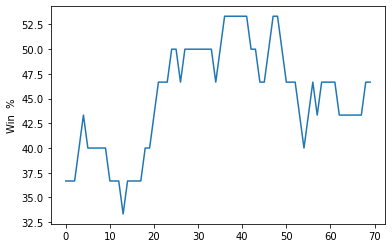

In [28]:
WIN_mean = []
window = 30

for i in range(len(WIN)-window):
    ten_kekka = WIN[i:i+window]
    WIN_mean.append(100 * np.mean(ten_kekka))

X = range(len(WIN_mean))
plt.plot( X, WIN_mean )
plt.ylabel("Win  %")

Text(0, 0.5, 'Miss  %')

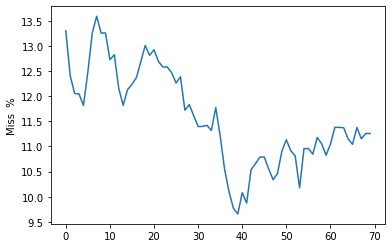

In [29]:
MISSES_mean = []
window = 30

for i in range(len(MISSES)-window):
    ten_kekka = MISSES[i:i+window]
    MISSES_mean.append(np.mean(ten_kekka))

X = range(len(MISSES_mean))
plt.plot( X, MISSES_mean )
plt.ylabel("Miss  %")

Text(0, 0.5, 'Miss_CPU  %')

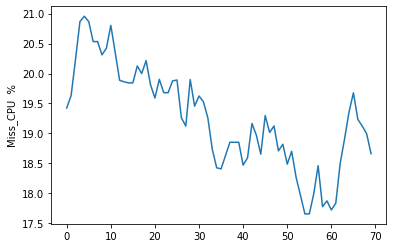

In [30]:
MISSES_mean = []
window = 30

for i in range(len(MISSES_CPU)-window):
    ten_kekka = MISSES_CPU[i:i+window]
    MISSES_mean.append(np.mean(ten_kekka))

X = range(len(MISSES_mean))
plt.plot( X, MISSES_mean )
plt.ylabel("Miss_CPU  %")

In [ ]:
torch.save( AAA.Agent.Network.state_dict(), "/content/drive/MyDrive/OTHELLO/SL_models/SL_Network_1_epoch_10-1.pth" )

# お試しプレイ


 CPUs state Input !!!!!!!!!!!!!!!!!


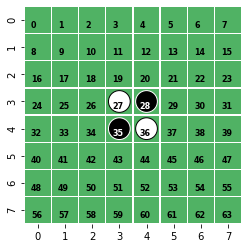

CPUs Action : (5, 3)


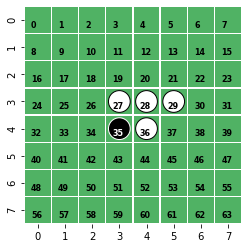

In [214]:
#CPU_MODEL_PATH = "/content/drive/MyDrive/OTHELLO/SL_models/SL_Network_1_epoch_12.pth"
CPU_MODEL_PATH = "/content/drive/MyDrive/OTHELLO/SL_models/SLpn_conv4_bn_mini_30.pth"
AAA = OTHELLO_Task(player_color='W' , view_board=True)
S = AAA.reset()
plt_img(S)


 Humans state Input !!!!!!!!!!!!!!!!!


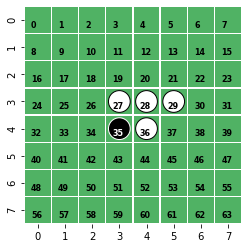

Humans Action : (5, 4)

 CPUs state Input !!!!!!!!!!!!!!!!!


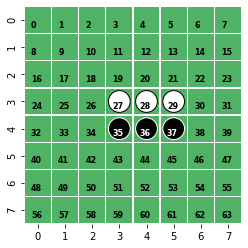

CPUs Action : (5, 5)


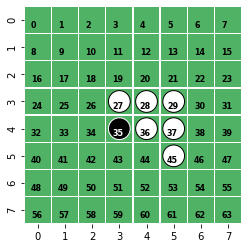

In [215]:
action = 37
S = AAA.step(action)
plt_img(S[0])